<a href="https://colab.research.google.com/github/MarwaRayen/Smart-Irrigation-System/blob/main/LSTM_VS_Double_LSTM_VS_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 1. Load and Preprocess Data
df = pd.read_csv('tomates.csv')
# df.rename(columns={'time': 'ds', 'water': 'y'}, inplace=True)
df['time'] = pd.to_datetime(df['time'], unit='s')
df


,simulation_id,time,water,hour
0,0,2016-01-01 07:00:00,36.86,14.0
1,1,2016-01-01 11:00:00,38.13,12.0
2,2,2016-01-01 15:00:00,21.22,16.0
3,3,2016-01-01 09:00:00,15.26,10.0
4,4,2016-01-01 07:00:00,9.47,8.0
...,...,...,...,...
9994,9994,2021-06-24 13:00:00,203.39,14.0
9995,9995,2021-06-24 11:00:00,0.88,12.0
9996,9996,2021-06-24 15:00:00,0.86,16.0
9997,9997,2021-06-24 09:00:00,0.04,10.0


In [ ]:
df.drop(columns=["simulation_id", "hour"])

,time,water
0,2016-01-01 07:00:00,36.86
1,2016-01-01 11:00:00,38.13
2,2016-01-01 15:00:00,21.22
3,2016-01-01 09:00:00,15.26
4,2016-01-01 07:00:00,9.47
...,...,...
9994,2021-06-24 13:00:00,203.39
9995,2021-06-24 11:00:00,0.88
9996,2021-06-24 15:00:00,0.86
9997,2021-06-24 09:00:00,0.04


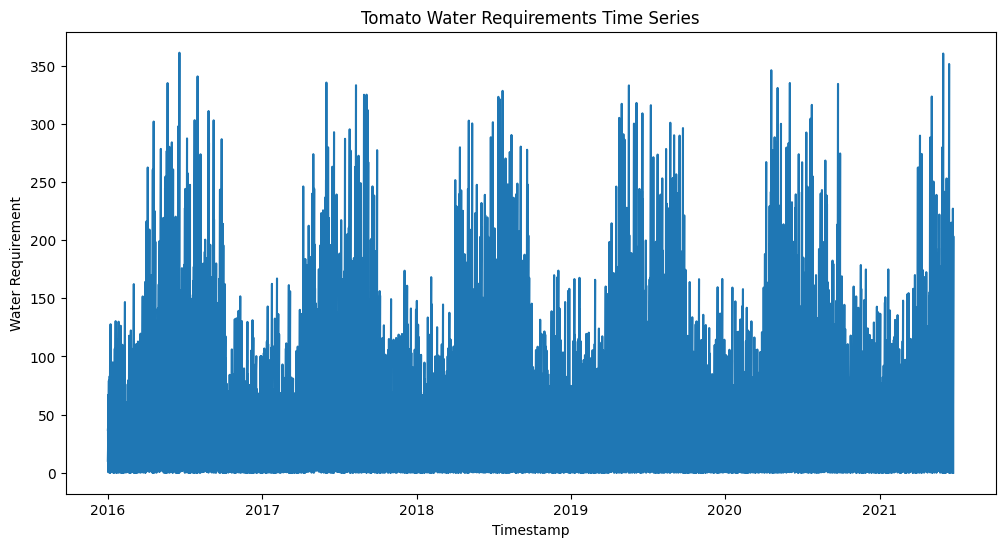

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['water'])
plt.xlabel('Timestamp')
plt.ylabel('Water Requirement')
plt.title('Tomato Water Requirements Time Series')
plt.show()

# LSTM

In [ ]:
water = df['water']

In [ ]:
water

0        36.86
1        38.13
2        21.22
3        15.26
4         9.47
         ...  
9994    203.39
9995      0.88
9996      0.86
9997      0.04
9998      0.00
Name: water, Length: 9999, dtype: float64

In [ ]:
def df_to_x_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  Y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    Y.append(label)
  return np.array(X), np.array(Y)

In [ ]:
WS= 5
X, Y = df_to_x_y(water, WS)
X.shape, Y.shape

((9994, 5, 1), (9994,))

In [ ]:
X

array([[[3.6860e+01],
        [3.8130e+01],
        [2.1220e+01],
        [1.5260e+01],
        [9.4700e+00]],

       [[3.8130e+01],
        [2.1220e+01],
        [1.5260e+01],
        [9.4700e+00],
        [6.7020e+01]],

       [[2.1220e+01],
        [1.5260e+01],
        [9.4700e+00],
        [6.7020e+01],
        [7.7900e+00]],

       ...,

       [[3.1800e+00],
        [1.0000e-02],
        [2.7600e+00],
        [2.0339e+02],
        [8.8000e-01]],

       [[1.0000e-02],
        [2.7600e+00],
        [2.0339e+02],
        [8.8000e-01],
        [8.6000e-01]],

       [[2.7600e+00],
        [2.0339e+02],
        [8.8000e-01],
        [8.6000e-01],
        [4.0000e-02]]])

In [ ]:
x_train, y_train = X[:8000], Y[:8000]
x_test, y_test = X[8000:], Y[8000:]
x_val, y_val = X[7000:8000], Y[7000:8000]

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((8000, 5, 1), (8000,), (1000, 5, 1), (1000,), (1994, 5, 1), (1994,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError



In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(WS, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp = ModelCheckpoint('double_lstm_model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
250/250 [==============================] - 6s 8ms/step - loss: 4081.0491 - root_mean_squared_error: 63.8831 - val_loss: 2863.7065 - val_root_mean_squared_error: 53.5136
Epoch 2/10
250/250 [==============================] - 1s 4ms/step - loss: 3623.5325 - root_mean_squared_error: 60.1958 - val_loss: 2449.6436 - val_root_mean_squared_error: 49.4939
Epoch 3/10
250/250 [==============================] - 1s 4ms/step - loss: 3210.2158 - root_mean_squared_error: 56.6588 - val_loss: 2265.6348 - val_root_mean_squared_error: 47.5987
Epoch 4/10
250/250 [==============================] - 1s 4ms/step - loss: 3019.8992 - root_mean_squared_error: 54.9536 - val_loss: 2199.8469 - val_root_mean_squared_error: 46.9025
Epoch 5/10
250/250 [==============================] - 1s 5ms/step - loss: 2928.0857 - root_mean_squared_error: 54.1118 - val_loss: 2173.5103 - val_root_mean_squared_error: 46.6209
Epoch 6/10
250/250 [==============================] - 1s 4ms/step - loss: 2865.8003 - root_mean_squa

In [ ]:
test_pred = model.predict(x_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_pred, 'Actual': y_test})
test_results

63/63 [==============================] - 0s 2ms/step


,Test Predictions,Actual
0,45.558681,26.40
1,19.638399,59.50
2,19.588518,14.16
3,25.553118,68.49
4,34.479221,170.08
...,...,...
1989,37.304943,203.39
1990,26.183510,0.88
1991,9.428746,0.86
1992,13.639868,0.04


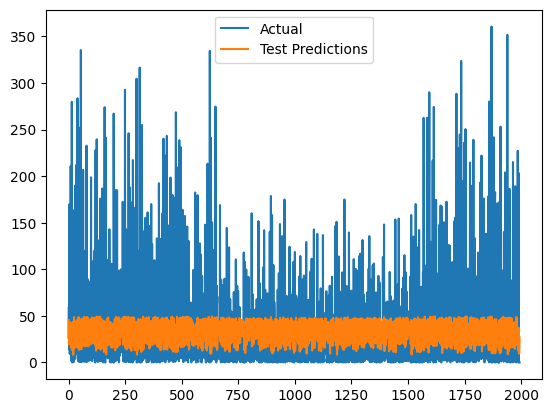

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_results['Actual'], label='Actual')
plt.plot(test_results['Test Predictions'], label='Test Predictions')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, test_pred)
print(f"Mean Squared Error on test data: {mse}")

Mean Squared Error on test data: 2813.8208535897575


# Double LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

# Load and preprocess the data
df = pd.read_csv('tomates.csv')
df['time'] = pd.to_datetime(df['time'])


# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['water']])

# Prepare the data for LSTM
def create_sequences(data, window_size):
    X = []
    Y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        Y.append(data[i + window_size])
    return np.array(X), np.array(Y)

WS = 5
X, Y = create_sequences(scaled_data, WS)

# Split the data
x_train, y_train = X[:8000], Y[:8000]
x_val, y_val = X[7000:8000], Y[7000:8000]
x_test, y_test = X[8000:], Y[8000:]

# Define the double LSTM model
def create_double_lstm(input_shape):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    return model

double_lstm_model = create_double_lstm((WS, 1))

# Train the model
cp = ModelCheckpoint('double_lstm_model/', save_best_only=True)
double_lstm_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, callbacks=[cp])

Epoch 1/50
250/250 [==============================] - 14s 40ms/step - loss: 0.0230 - root_mean_squared_error: 0.1518 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1289
Epoch 2/50
250/250 [==============================] - 9s 37ms/step - loss: 0.0208 - root_mean_squared_error: 0.1441 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1248
Epoch 3/50
250/250 [==============================] - 8s 34ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1245
Epoch 4/50
250/250 [==============================] - 10s 38ms/step - loss: 0.0182 - root_mean_squared_error: 0.1350 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188
Epoch 5/50
250/250 [==============================] - 10s 41ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 6/50
250/250 [==============================] - 2s 8ms/step - loss: 0.0179 - root_mean_squared_error: 0.1338 - val_loss: 0.014

In [ ]:
double_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 50449 (197.07 KB)
Trainable params: 5044

63/63 [==============================] - 1s 3ms/step


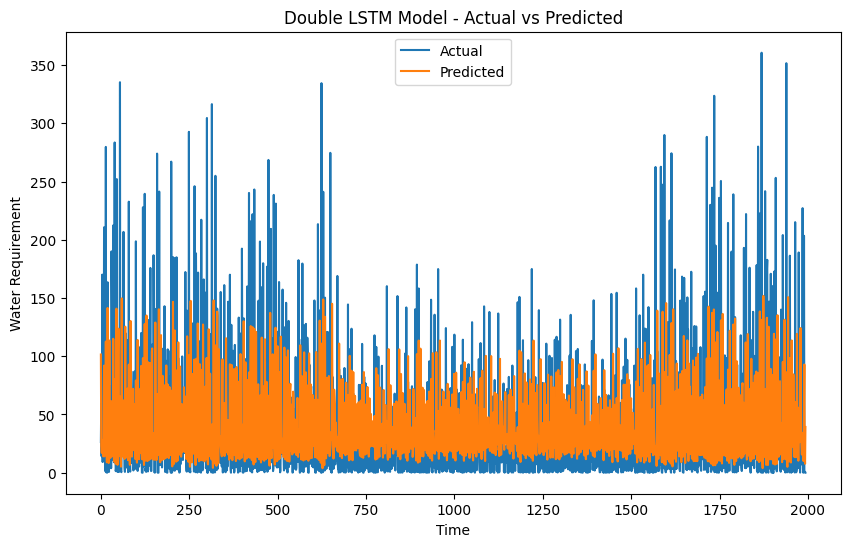

In [ ]:
import matplotlib.pyplot as plt


# Predict on the test set
y_pred = double_lstm_model.predict(x_test)

# Inverse transform the predictions and actual values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted')
plt.title('Double LSTM Model - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Water Requirement')
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"Mean Squared Error on test data: {mse}")

Mean Squared Error on test data: 2358.0091195839036


# R-CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense

def create_r_cnn(seq_length, num_features):
    input_layer = Input(shape=(seq_length, num_features))

    # Convolutional layers
    conv1 = Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=64, kernel_size=2, activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    # Flatten and Dense layers
    flat = Flatten()(pool2)
    dense1 = Dense(50, activation='relu')(flat)
    output_layer = Dense(num_features)(dense1)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model

# Prepare the data for R-CNN
X, y = create_sequences(scaled_data, 60)

# Split the data
x_train, y_train = X[:8000], Y[:8000]
x_val, y_val = X[7000:8000], Y[7000:8000]
x_test, y_test = X[8000:], Y[8000:]

# Create and train the R-CNN model
r_cnn_model = create_r_cnn(60, 1)
r_cnn_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/50
250/250 [==============================] - 3s 6ms/step - loss: 0.0067 - val_loss: 0.0016
Epoch 2/50
250/250 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/50
250/250 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 8.5824e-04
Epoch 4/50
250/250 [==============================] - 1s 6ms/step - loss: 7.9955e-04 - val_loss: 4.5886e-04
Epoch 5/50
250/250 [==============================] - 1s 5ms/step - loss: 6.3972e-04 - val_loss: 5.1135e-04
Epoch 6/50
250/250 [==============================] - 1s 5ms/step - loss: 4.8472e-04 - val_loss: 2.6122e-04
Epoch 7/50
250/250 [==============================] - 2s 6ms/step - loss: 4.7161e-04 - val_loss: 3.5878e-04
Epoch 8/50
250/250 [==============================] - 3s 10ms/step - loss: 4.0516e-04 - val_loss: 2.5869e-04
Epoch 9/50
250/250 [==============================] - 2s 6ms/step - loss: 4.9595e-04 - val_loss: 3.0934e-04
Epoch 10/50
250/250 [==========================

In [ ]:
r_cnn_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 59, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 64)            8256      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 896)               0     

61/61 [==============================] - 0s 4ms/step


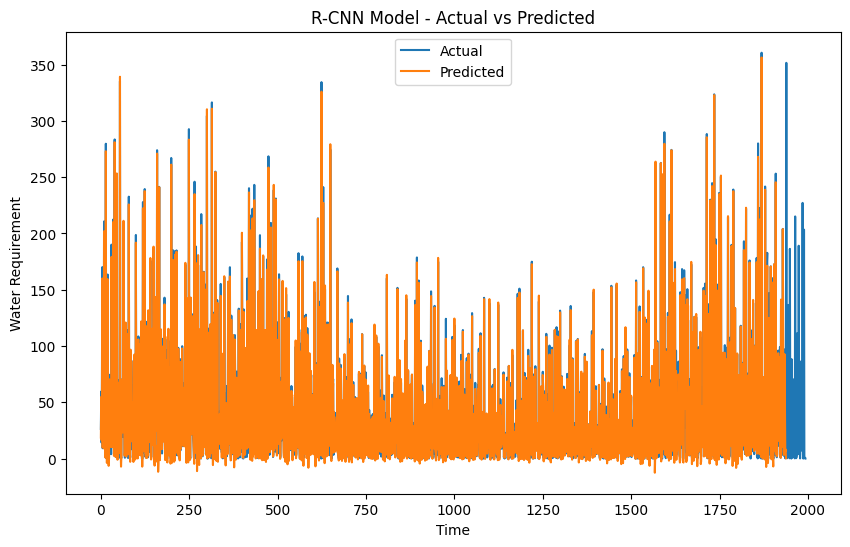

In [ ]:
# Predict on the test set
y_pred = r_cnn_model.predict(x_test)

# Inverse transform the predictions and actual values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted')
plt.title('R-CNN Model - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Water Requirement')
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(y_test_inverse[:1939], y_pred_inverse)
print(f"Mean Squared Error on test data: {mse}")

Mean Squared Error on test data: 22.50508913898835
